# Sorted circuit parameters

Let's start with a simple parameterized circuit...

In [1]:
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector

a, b, c = [Parameter(name) for name in 'abc']
circuit = QuantumCircuit(2)
circuit.h([0, 1])
circuit.rz(a, 0)
circuit.rx(b, 1)
circuit.cx(0, 1)
circuit.ry(c, 1)

circuit.draw()

┌───┐┌───────┐              
q_0: ┤ H ├┤ RZ(a) ├──■───────────
     ├───┤├───────┤┌─┴─┐┌───────┐
q_1: ┤ H ├┤ RX(b) ├┤ X ├┤ RY(c) ├
     └───┘└───────┘└───┘└───────┘

Instead of a set of unordered parameters, the return type is now a ``ParameterView``.

In [2]:
circuit.parameters

ParameterView([Parameter(a), Parameter(b), Parameter(c)])

This is similar to the ``KeysView`` object of a dictionary, except it allows indexing. This allows to treat numeric parameter-arrays and symbolic parameter-arrays more similarly.

In [3]:
print(circuit.parameters[0])
print(circuit.parameters[1:])

a
[Parameter(b), Parameter(c)]


An order allows us to assign parameter values by an array instead of a `{parameter: value}` dictionary.

In [4]:
values = [1, 2, 3]
circuit.assign_parameters(values).draw()

┌───┐┌───────┐              
q_0: ┤ H ├┤ RZ(1) ├──■───────────
     ├───┤├───────┤┌─┴─┐┌───────┐
q_1: ┤ H ├┤ RX(2) ├┤ X ├┤ RY(3) ├
     └───┘└───────┘└───┘└───────┘

Partial binding still requires to pass the dictionary.

In [5]:
# values = [1, 2]
# circuit.assign_parameters(values).draw()  # error mismatching dims

In [6]:
circuit.assign_parameters({a: 1, b: 2}).draw()

┌───┐┌───────┐              
q_0: ┤ H ├┤ RZ(1) ├──■───────────
     ├───┤├───────┤┌─┴─┐┌───────┐
q_1: ┤ H ├┤ RX(2) ├┤ X ├┤ RY(c) ├
     └───┘└───────┘└───┘└───────┘

### Anonymous binding in action

Anonymous binding (aka binding with an array) is especially useful if circuits are passed around or constructed for you (e.g. from the circuit library).

In [7]:
def secret_circuit():
    params = ParameterVector('p', 4)
    circuit = QuantumCircuit(2)
    circuit.h(0)
    for param in params:
        circuit.p(param, 1)
        circuit.cx(0, 1)
    circuit.h(0)
    
    return circuit

circuit = secret_circuit()
circuit.draw()

┌───┐                                                        ┌───┐
q_0: ───┤ H ├─────■───────────────■───────────────■───────────────■──┤ H ├
     ┌──┴───┴──┐┌─┴─┐┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐└───┘
q_1: ┤ P(p[0]) ├┤ X ├┤ P(p[1]) ├┤ X ├┤ P(p[2]) ├┤ X ├┤ P(p[3]) ├┤ X ├─────
     └─────────┘└───┘└─────────┘└───┘└─────────┘└───┘└─────────┘└───┘

Let's try to assign some values.

In [8]:
import numpy as np

values = np.arange(circuit.num_parameters)

We previously had to pass a dictionary of values. But how do we create this dictionary?

Attempt 1: Just call `list(circuit.parameters)` and use that.

In [9]:
param_dict = dict(zip(list(circuit.parameters), values))  

Problem: Not consistent! Every time you run this script the values are mapped in a different order.

Attempt 2: Impose some order and sort the parameters manually.

In [10]:
sorted_params = sorted(circuit.parameters, key=lambda p: p.name)
param_dict = dict(zip(sorted_params, values))

Works, but is this really intuitive sorting? 

In [11]:
params = ParameterVector('theta', 11)
sorted_params = sorted(params, key=lambda p: p.name)
for i, sorted_param in enumerate(sorted_params):
    print(f'{i}: {sorted_param}')

0: theta[0]
1: theta[10]
2: theta[1]
3: theta[2]
4: theta[3]
5: theta[4]
6: theta[5]
7: theta[6]
8: theta[7]
9: theta[8]
10: theta[9]


#### Note

All our built-in algorithms handling parameters currently do the above to ensure reproducibility. But the cost is that the assignment can be non-intuitive.

Now, we already have an order and can just do.

In [12]:
circuit.assign_parameters(values)

#### A less standard example

Imagine a user playing with their own circuit or a researcher plugging circuits together!

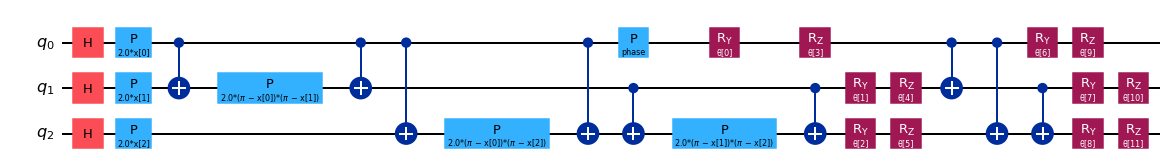

In [13]:
from qiskit.circuit.library import ZZFeatureMap, EfficientSU2

phase = Parameter('phase')
ansatz = ZZFeatureMap(3, reps=1)
ansatz.p(phase, 0)
ansatz.compose(EfficientSU2(3, reps=1), inplace=True)
ansatz.draw(output='mpl', style='iqx')

### Optimization

This direct assignment of arrays is especially valuable in optimization, since classical subroutines always handle parameters as arrays of values.

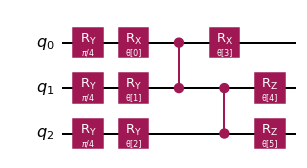

In [14]:
from qiskit.circuit.library import PauliTwoDesign
from qiskit.opflow import Z, I, CircuitSampler, StateFn

observable = Z ^ Z ^ I
ansatz = PauliTwoDesign(3, reps=1)
ansatz.draw(output='mpl', style='iqx')

In [15]:
def cost_function(values):
    bound = ansatz.assign_parameters(values)
    expectation_value = ~StateFn(observable) @ StateFn(bound)
    return expectation_value.eval().real

In [16]:
cost_function(np.zeros(6))

0.0

In [17]:
from scipy.optimize import minimize

initial_guess = np.random.random(ansatz.num_parameters)
maxiter = 100

# runs too long for this tutorial ;)
# minimize(cost_function, initial_guess, method='bfgs', options={'maxiter': maxiter})  

Our built-in optimization algorithms (VQE, QAOA) can now also use this order instead of sort parameters by name and stay consistent with the users input.

### Composing

When composing circuits, the parameters are composed in the same order as the circuit.

In [18]:
x, y = Parameter('x'), Parameter('y')

other = QuantumCircuit(2)
other.rxx(x, 0, 1)
other.ryy(y, 0, 1)

composed = circuit.compose(other)
composed.draw()

┌───┐                                                        ┌───┐»
q_0: ───┤ H ├─────■───────────────■───────────────■───────────────■──┤ H ├»
     ┌──┴───┴──┐┌─┴─┐┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐└───┘»
q_1: ┤ P(p[0]) ├┤ X ├┤ P(p[1]) ├┤ X ├┤ P(p[2]) ├┤ X ├┤ P(p[3]) ├┤ X ├─────»
     └─────────┘└───┘└─────────┘└───┘└─────────┘└───┘└─────────┘└───┘     »
«     ┌─────────┐┌─────────┐
«q_0: ┤0        ├┤0        ├
«     │  RXX(x) ││  RYY(y) │
«q_1: ┤1        ├┤1        ├
«     └─────────┘└─────────┘

Circuit + Other returns ```[a b c] [x y]```

In [19]:
composed.parameters

ParameterView([Parameter(p[0]), Parameter(p[1]), Parameter(p[2]), Parameter(p[3]), Parameter(x), Parameter(y)])

Other + Circuit returns ``[x y] [a b c]`` (using the ``front`` keyword here)

In [20]:
circuit.compose(other, front=True).parameters

ParameterView([Parameter(x), Parameter(y), Parameter(p[0]), Parameter(p[1]), Parameter(p[2]), Parameter(p[3])])

### Appending

In [27]:
first = QuantumCircuit(1)
first.p(x, 0)

second = QuantumCircuit(1)
second.rz(y, 0)

first.append(second, [0])
print(first.parameters)

ParameterView([Parameter(x), Parameter(y)])


### Tensoring

TODO could argue for both orders.

When tensoring, the parameters of the top circuit are coming first. (status quo)

When tensoring, the parameters of the leftmost object in the tensorproduct are coming first.

In [21]:
circuit.tensor(other).parameters

ParameterView([Parameter(x), Parameter(y), Parameter(p[0]), Parameter(p[1]), Parameter(p[2]), Parameter(p[3])])

### Conversion to DAG and back

In [22]:
from qiskit.converters import circuit_to_dag, dag_to_circuit

dag = circuit_to_dag(circuit)
circuit2 = dag_to_circuit(dag)

circuit2.draw()

┌───┐                                                        ┌───┐
q_0: ───┤ H ├─────■───────────────■───────────────■───────────────■──┤ H ├
     ┌──┴───┴──┐┌─┴─┐┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐└───┘
q_1: ┤ P(p[0]) ├┤ X ├┤ P(p[1]) ├┤ X ├┤ P(p[2]) ├┤ X ├┤ P(p[3]) ├┤ X ├─────
     └─────────┘└───┘└─────────┘└───┘└─────────┘└───┘└─────────┘└───┘

In [23]:
circuit2.parameters

ParameterView([Parameter(p[0]), Parameter(p[1]), Parameter(p[2]), Parameter(p[3])])

### Transpiling

In [24]:
from qiskit import transpile

In [25]:
transpiled = transpile(composed, basis_gates=['u', 'cx'], optimization_level=0)
transpiled.parameters

ParameterView([Parameter(p[0]), Parameter(p[1]), Parameter(p[2]), Parameter(p[3]), Parameter(x), Parameter(y)])

In [26]:
transpiled = transpile(composed, basis_gates=['u', 'cx'], optimization_level=3)
transpiled.parameters

ParameterView([Parameter(p[0]), Parameter(p[1]), Parameter(p[2]), Parameter(p[3]), Parameter(x), Parameter(y)])

In [59]:
from qiskit.circuit.library import PhaseEstimation, GroverOperator, LinearPauliRotations, QFT

In [44]:
oracle = QuantumCircuit(3)
oracle.z(2)

a = LinearPauliRotations(2, slope=0.2, offset=1)

In [54]:
u = QuantumCircuit(1)
u.rz(0.2, 0)

In [56]:
PhaseEstimation(2, u).decompose().draw()

┌─────────┐                                                  ┌───┐
eval_0: ┤ U2(0,π) ├────────■───────────────────────────────────■─────┤ H ├
        ├─────────┤        │                         ┌───┐┌────┴────┐└───┘
eval_1: ┤ U2(0,π) ├────────┼────────────────■────────┤ H ├┤ P(-π/2) ├─────
        └─────────┘┌───────┴───────┐┌───────┴───────┐└───┘└─────────┘     
   q_0: ───────────┤ circuit831**1 ├┤ circuit831**2 ├─────────────────────
                   └───────────────┘└───────────────┘

In [63]:
a = Parameter('α')
pec = QuantumCircuit(3)
pec.h([0, 1])
pec.crz(a, 0, 2)
pec.crz(2 * a, 1, 2)
pec.compose(QFT(2, do_swaps=False).inverse(), [0, 1], inplace=True)

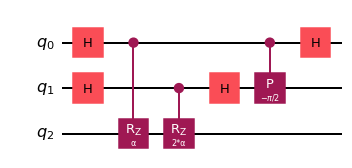

In [68]:
pec.draw(output='mpl', style='iqx', filename='pec.pdf')

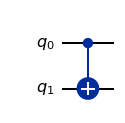

In [79]:
u = QuantumCircuit(2)
u.cx(0, 1)
u.draw(output='mpl', style='iqx', filename='cx.pdf')

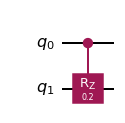

In [83]:
rz = QuantumCircuit(2)
rz.crz(0.2, 0, 1)
rz.draw(output='mpl', style='iqx', filename='rz.pdf')

In [84]:
rz.decompose().draw()

q_0: ─────────────■────────────────■──
     ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐
q_1: ┤ U1(0.1) ├┤ X ├┤ U1(-0.1) ├┤ X ├
     └─────────┘└───┘└──────────┘└───┘